Họ và tên: **Nguyễn Ngọc Băng Tâm**

MSSV: **1712747**

## Cấu trúc các file bài làm
- 5 file notebook tương ứng 5 module cần cài đặt
    - Module 1: Crawl dữ liệu bằng API
    - Module 2: Crawl dữ liệu bằng Selenium + HTML
    - Module 3: Parse dữ liệu bằng HTML và lưu xuống file csv
    - Module 4: Làm sạch và tiền xử lý dữ liệu
    - Module 5: EDA
- 3 folder chứa dữ liệu
    - Api_data: 3 file csv từ API
    - Crawl_data: 6 file csv, gồm 3 file dữ liệu thô và 3 file dữ liệu đã làm sạch
    - Crawl_urls: 6 file txt chứa các url trung gian, phục vụ quá trình crawl dữ liệu

## I - Crawl dữ liệu

**Quy trình :**
- Tìm top 300 từ khóa phổ biến trong 24h qua và lưu vào tập tin `popular_keywords.txt`
- Lựa chọn danh sách các playlist thuộc top 300 từ khóa đó và lưu vào tập tin `query_popular_playlists.txt`
- Thực hiện parse HTMl để tìm các playlist của mỗi url truy vấn playlist và lưu vào `popular_playlists.txt`, đồng thời xử lý các playlist trùng và lưu vào tập tin `unique_popular_playlists.txt`
- Từ mỗi url playlist, parse url của user là người đăng playlist (hay chủ của playlist) đó, xử lý trường hợp trùng lắp và lưu vào tập tin `unique_popular_users.txt`
- Cũng từ mỗi url playlist, sử dụng regex để parse được url của 5 track thuộc playlist đó, xử lý trường hợp trùng và lưu vào tập tin `unique_popular_tracks.txt`

## II - Dự đoán
- Trước khi tìm hiểu dữ liệu, ta xác định một số mong đợi về tập dữ liệu Soundcloud:
    - Với mỗi tập dữ liệu, tìm những đối tượng theo yếu tốt nhiều nhất, ít nhất, phổ biến nhất?
    - Ví dụ:
        - Thể loại nhạc nào đang được tìm kiếm nhiều nhất trong 24 giờ qua (tính tới thời điểm ngày 05/11)?
        - Playlist nào được yêu thích nhiều nhất?
        - Track nhạc nào được yêu thích nhiều nhất? Nhiều lượt chia sẻ nhất?
    - Có album hoặc bài hát nào đang là hit gần đây (định nghĩa hit được tạm quy định: nếu bài hát được đăng rất gần đây nhưng có lượt nghe và yêu thích nhiều)

    - Có tồn tại bài hát nào được yêu thích nhiều nhưng lượt nghe ít?
    
    - Yếu tố nào quyết định một bài hát được yêu thích (hoặc nghe nhiều)?
        - Liệu bài nhạc ngắn hơn hay dài hơn sẽ được nhiều người nghe hơn?
    - Với các album, yếu tố nào quyết định album đó được nhiều người yêu thích? 
        - Số lượng track trong album nhiều hay ít?
    - Có thể loại nhạc mới nào xuất hiện trong top các playlist hoặc track được tìm kiếm? Thể loại nhạc được xem là mới nếu nó không nằm trong danh sách thể loại mặc định của Soundcloud
    
    - Với tập user:
        - Yếu tố nào quyết định một người dùng được quan tâm (độ được quan tâm đánh giá bằng số followers)?
            - badge = pro_unlimited
      
        - Với các người dùng được nhiều follower, liệu có phải các playlist mà họ upload sẽ nhận được lượng likes, reposts và playback nhiều hơn?

## III - EDA

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

### 1. Tập playlist

In [60]:
playlist = pd.read_csv('Crawl_data/selected_playlists.csv', sep='\t')
playlist.head()

,id,duration,genre,likes_count,reposts_count,user_id,set_type,track_counts,tracks,is_purchasable,display_time
0,310741832,40935252,Country,2035,103,273587555,normal_playlist,189,"111350611,127711350,89291705,221922037,2557906...",False,43.486187
1,1143112054,37740984,Hip hop/rap,0,0,667588841,normal_playlist,181,"877524697,877524238,877523905,877523803,877523...",False,1.012377
2,971808526,15552646,Alternative rock,12,0,769710073,normal_playlist,76,"547941324,5284026,579807702,685678354,33010377...",False,9.603835
3,149404857,66544676,Beats,234,28,177229326,normal_playlist,203,"19320434,215361560,216352962,43248780,21468388...",False,61.426899
4,361670771,9427177,Alternative,5548,278,339239709,normal_playlist,50,"332962988,333923891,329430750,335860168,308016...",False,36.646035


In [61]:
# Kiểm tra số mẫu và thuộc tính đã chọn
playlist.shape

(2368, 11)

In [62]:
playlist['id'] = playlist['id'].astype('object')
playlist['user_id'] = playlist['user_id'].astype('object')

**Tóm tắt:**

|Thuộc tính|Kiểu dữ liệu|     Ý nghĩa   |Miền giá trị |
|:--------:|:-------------:|:-----:|:-----:|
|**id**|Chuỗi|Định danh của playlist||
|**duration**|Số nguyên|Tổng thời gian các track nhạc trong playlist|Liên tục (đơn vị: mili giây)|
|**genre**|Chuỗi|Thể loại nhạc của playlist| 53 thể loại nhạc |
|**likes_count**|Số nguyên|Thể loại nhạc của playlist|Liên tục|
|**reposts_count**|Số nguyên|Số lượt đăng lại playlist| Liên tục  |
|**user_id**|Chuỗi|Định danh chủ của playlist||
|**set_type**|Chuỗi|Định dạng đĩa của playlis|"normal_playlist", "album", "compilation", "ep", "single"|
|**track_counts**|Số nguyên|Số lượng track trong playlist|Liên tục |
|**tracks**|Chuỗi|Danh sách id của các track trong playlist|   |
|**is_purchasable**|Luận lý|Playlist có mục đích thương mại hay không|True hoặc False|
|**display_time**|Số thực|Thời gian playlist đã được đăng|Liên tục (đơn vị: tháng)|

#### a. Phân tích dữ liệu số

- Với phân tích đơn biến của dữ liệu số ta có 2 cách EDA: sử dụng các đại lượng thống kê và trực quan hóa
    - Các đại lượng thống kê: gồm 3 loại
        - Thống kê tính trung tâm (mean, median, mode và phân vị)
        - Thống kê tính bao phủ (phương sai, độ lệch chuẩn, miền giá trị)
        - Thống kê độ lệch (hình dáng) của phân phối xác suất
    - Trực quan hóa:
        - Dữ liệu liên tục: Histogram
        - Phát hiện outlier: Boxplot
        
- Tương tự với phân tích đa biến của dữ liệu số ta cũng có 2 cách EDA
    - Thống kê độ tương quan (hệ số Pearson)
    - Trực quan hóa: Scatterplot, pairplot và heatmap
  
      

#### a.1 Phân tích đơn biến

**Tiến hành rút trích dataframe con chỉ chứa dữ liệu số để thực hiện thống kê**

In [63]:
playlist_num = playlist.select_dtypes(include = ['float64', 'int64'])

In [64]:
playlist_num.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,2368.0,3.962867e+07,8.830254e+07,0.00000,7.665764e+06,2.877994e+07,3.774098e+07,2.234201e+09
likes_count,2368.0,8.880713e+03,3.208661e+04,0.00000,0.000000e+00,1.400000e+01,5.592500e+02,4.234520e+05
reposts_count,2368.0,8.622732e+02,3.714415e+03,0.00000,0.000000e+00,1.000000e+00,2.600000e+01,5.712200e+04
track_counts,2368.0,1.561368e+02,1.397693e+02,0.00000,3.600000e+01,1.360000e+02,1.810000e+02,5.000000e+02
display_time,2368.0,1.993106e+01,2.187210e+01,0.14984,1.237638e+00,1.233868e+01,3.092313e+01,1.198341e+02


**Trực quan hóa**

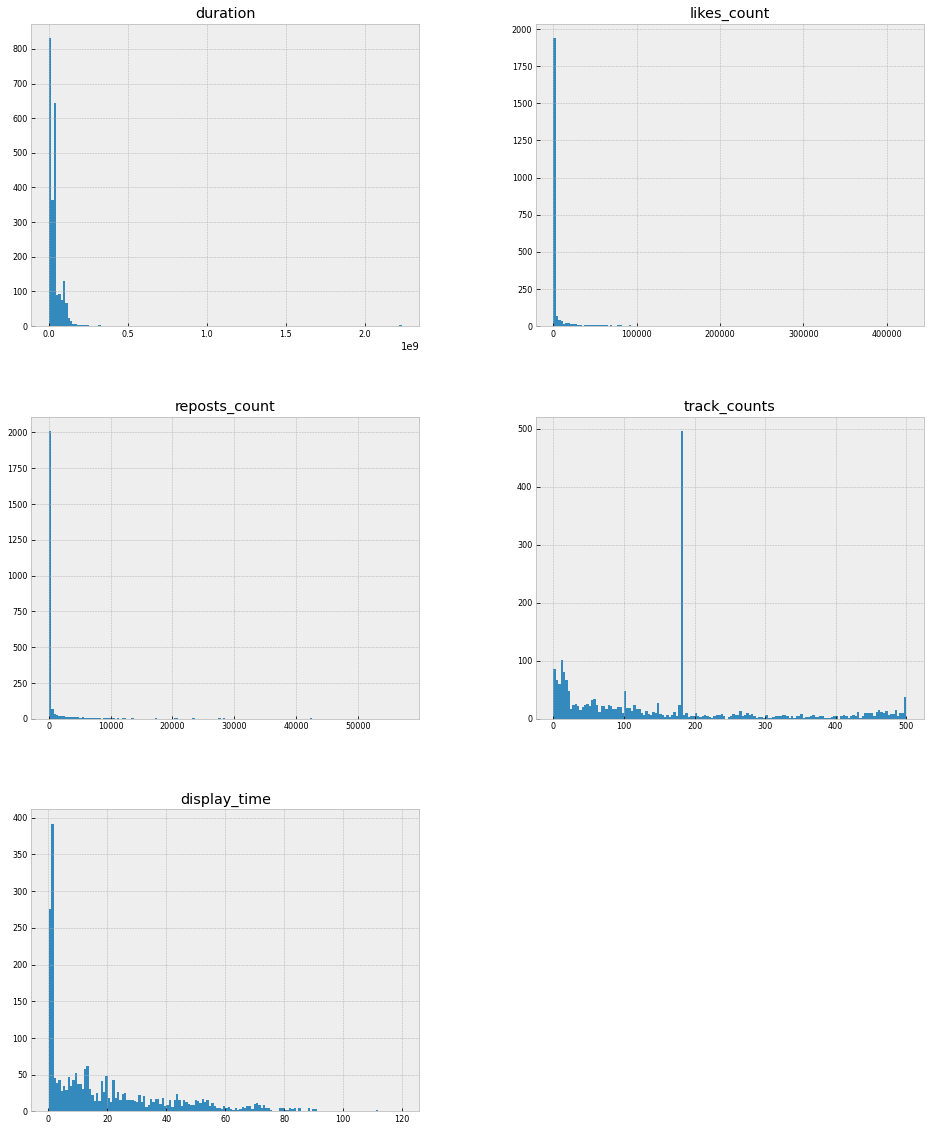

In [65]:
playlist_num.hist(figsize=(16, 20), bins=150, xlabelsize=8, ylabelsize=8);

**Nhận xét:**
- Các playlist được tìm kiếm nhiều thường có độ dài nhỏ (nhỏ hơn 8 giờ), tuy cũng có một vài playlist có độ dài lên đến hơn 69 giờ.
- Các playlist chủ yếu có lượt yêu thích dưới 10000, một số ít playlist đạt được độ yêu thích xấp xỉ 100000
- Số lượng tracks phổ biến của playlist nằm trong khoảng 175 - 185 track, có những playlist không chứa track nào và cũng có các playlist chứa đến 500 track
- `display_time` cho thấy các playlist được tìm kiếm nhiều nhất chủ yếu là các playlist trong 20 tháng (hơn 3 năm) gần đây, một số ít playlist dù đã được phát hành hơn 90 tháng (7.5 năm) vẫn được tìm kiếm. Đặc biệt, có playlist đã được phát hành cách đây hơn 110 tháng (hơn 9 năm) vẫn nằm trong top 300 playlist được tìm kiếm nhiều. Có thể playlist này là những bài nhạc huyền thoại và gần đây một sự kiện nào đó xảy ra dẫn đến playlist lại được quan tâm


##### a.1.1 Thuộc tính `likes_count`
- Hầu hết playlist có lượt likes khá ít, chỉ có vài playlist đạt số likes đặc biệt lớn

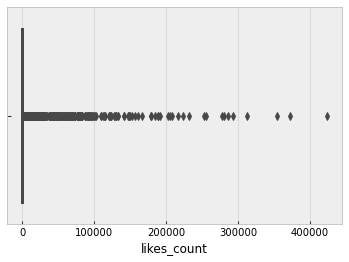

In [70]:
sns.boxplot(data=playlist_num, x='likes_count');

##### a.1.2 Thuộc tính `duration`
- Hầu hết playlist được tìm kiếm nhiều nhất có lượt tổng độ dài nhỏ, chỉ có 3 playlist có độ dài rất lớn

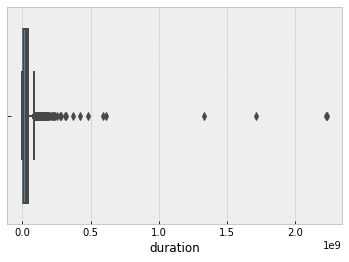

In [71]:
sns.boxplot(data=playlist_num, x='duration');

##### a.1.3 Thuộc tính `reposts_count`

##### a.1.4 Thuộc tính `track_counts`
- Hầu hết playlist có số lượng track trong khoảng 30 - 180 track, tuy nhiên vẫn có một số playlist chứa hơn 400 track

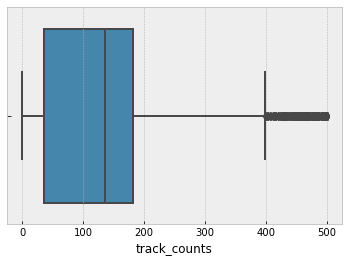

In [73]:
sns.boxplot(data=playlist_num, x='track_counts');

##### a.1.5 Thuộc tính `display_time`
- Hầu hết playlist được tìm kiếm nhiều là các playlist mới, xuất hiện trong khoảng hơn 2 năm gần đây.
- Tuy nhiên, có một vài playlist có "tuổi đời" khá lâu, từ 6 - 10 năm vẫn được tìm kiếm nhiều. Khả năng rất cao đây là những playlist nhạc kinh điển và nhân sự kiện nào đó mà người dùng quan tâm đến playlist nhạc này.

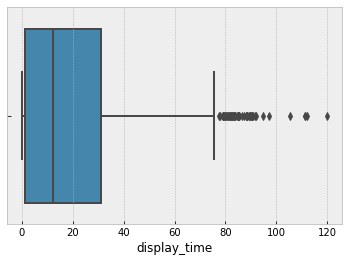

In [74]:
sns.boxplot(data=playlist_num, x='display_time');

#### a2. Phân tích đa biến

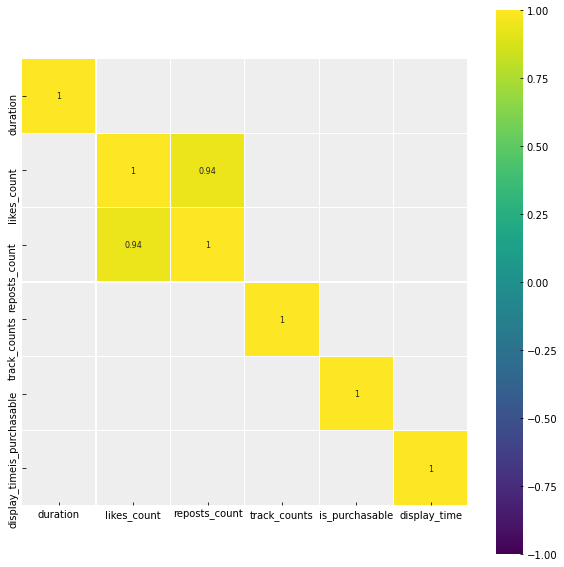

In [66]:
corr = playlist.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

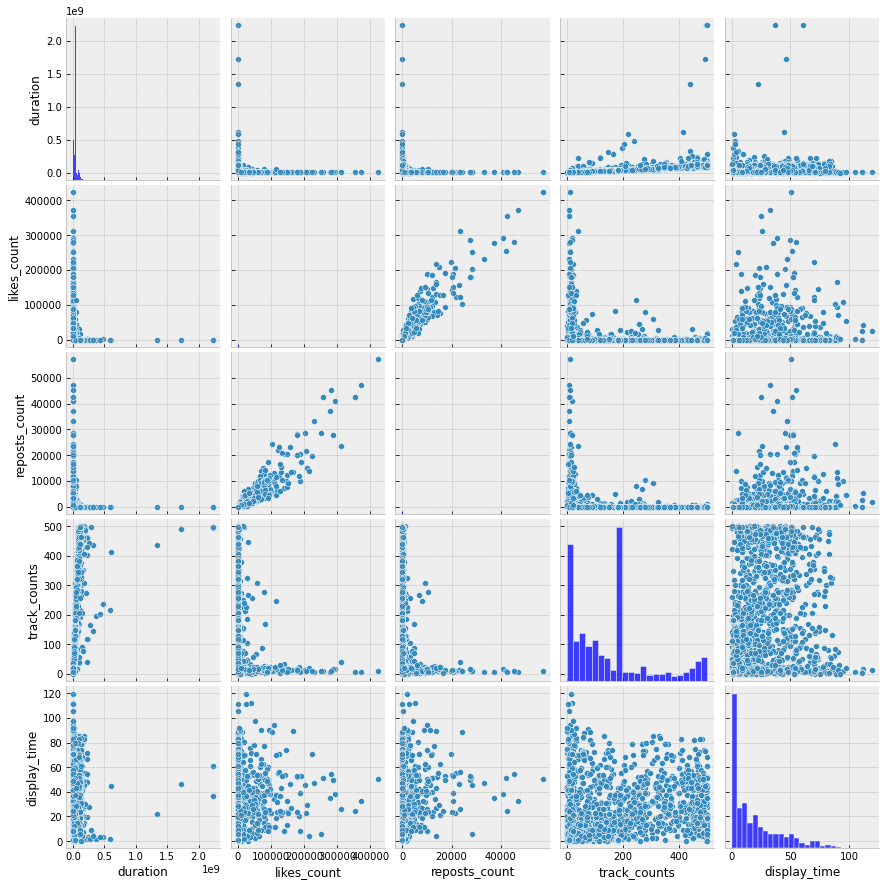

In [67]:
sns.pairplot(playlist_num)

Từ heatmap biểu diễn độ tương quan của các thuộc tính và pairplot, ta có nhận xét:
- `likes_count` và `reposts_count` có quan hệ tương quan thuận mạnh, cho thấy các playlist có độ yêu thích càng lớn thì khả năng càng cao được nhiều người chia sẻ và ngược lại
- Có những playlist có lượng track_counts lớn nhưng `duration` vẫn nhỏ, có thể vì độ dài mỗi track đều nhỏ nên dù số lượng track_counts lớn thì tổng thời gian của cả playlist vẫn không nhiều. Một vài playlist vừa có `track_counts` lớn vừa có `duration` lớn.

#### b. Phân tích dữ liệu rời rạc

Phân bố của trường `set_type`:
- Các playlist chủ yếu là các playlist thông thường, tức là các track trong playlist đó không nhất thiết thuộc cùng một nghệ sĩ
- Số lượng album bằng hơn 1/10 số playlist thông thường.

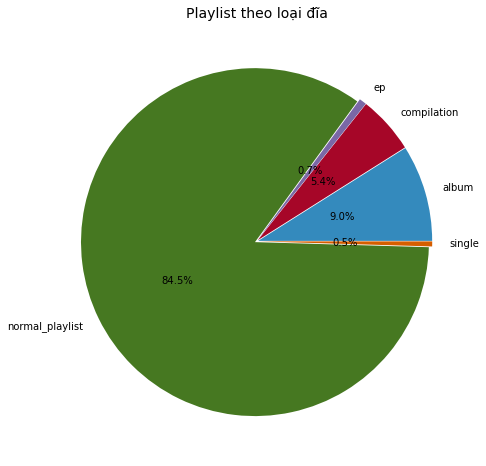

In [28]:
type_plot = playlist.groupby("set_type")["id"].count()
plt.figure(figsize=(8, 8))
plt.pie(x=type_plot, autopct="%.1f%%", explode=[0.01]*len(type_plot.keys()), labels=type_plot.keys(), pctdistance=0.5)
plt.title("Playlist theo loại đĩa", fontsize=14);

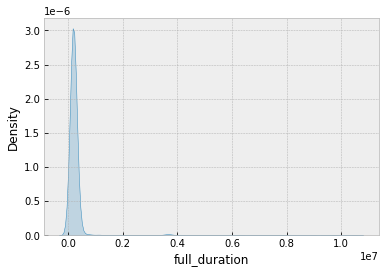

In [59]:
# so kdeplot của từng label ==> xem phân bố của likes_count giữa các category?
sns.kdeplot(track['full_duration'], shade=True);

Phân tích thể loại nhạc `genre`
- Lưu ý: Do số lượng `genre` lên đến 53 thể loại nên đồ án không trực quan hóa bằng biểu đồ tròn mà dùng biểu đồ cột để vẫn đảm bảo tính trực quan

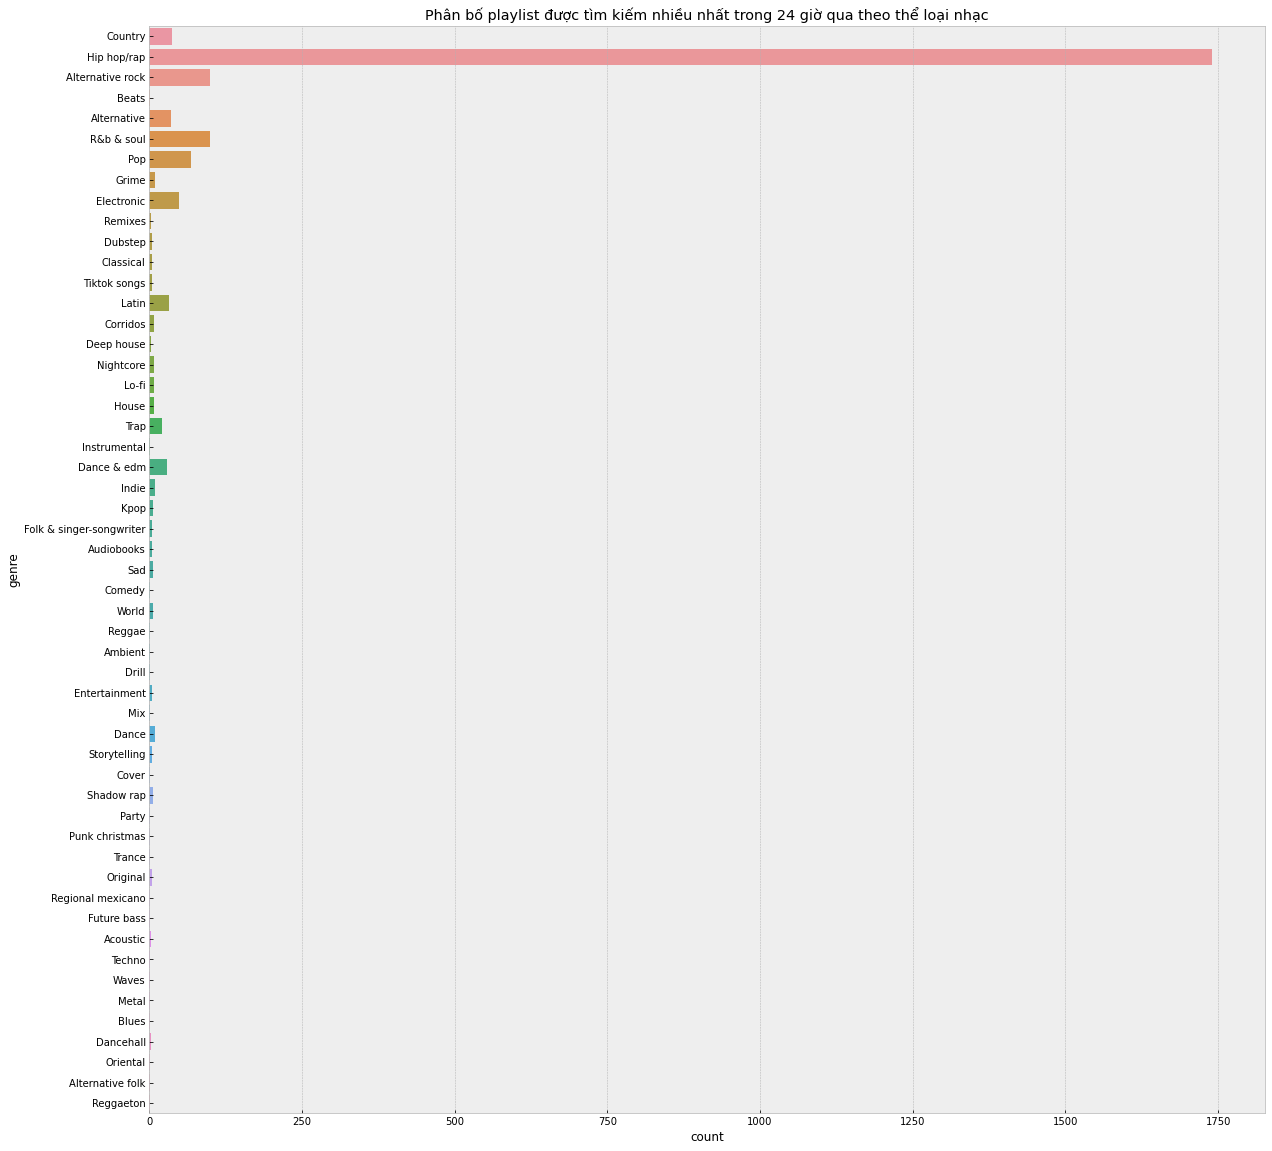

In [80]:
plt.figure(figsize=(20, 20))
sns.countplot(y="genre", data=playlist)
plt.title('Phân bố playlist được tìm kiếm nhiều nhất trong 24 giờ qua theo thể loại nhạc');

In [113]:
total_playlists = playlist.groupby(['genre'], as_index=False)['genre'].count().sum()[0]
playlist['percentage'] = playlist.groupby(['genre'], as_index=False)['genre'].count() / total_playlists * 100

In [122]:
print(f"Tỷ lệ của playlist thuộc thể loại Hip hop/Rap: {(playlist['percentage'].max()):.2f}%")

Tỷ lệ của playlist thuộc thể loại Hip hop/Rap: 73.48%


**Nhận xét:**
- Nhạc Hip hop / Rap được tìm kiếm nhiều nhất, kế đến là Alternative Rock và R&B
- Các loại nhạc hiếm như nhạc Giáng sinh, Techno,... có khá ít người tìm kiếm

Có thể do trong xu hướng hiện tại, Hip hop và Rap đều chiếm được sự quan tâm của khán giả nên mức độ tìm kiếm thể loại nhạc này cũng chiếm ưu thế.

- Ta tiếp tục phân tích xem thể loại nhạc nào nhận được nhiều sự yêu thích nhất. 
- Lưu ý: Do `likes_count` và `reposts_count` có mối quan hệ tương quan thuận, ta chỉ cần xét `likes_count` là có thể nội suy xu hướng của thuộc tính còn lại

**Tìm thể loại nhạc của các playlist được yêu thích nhiều nhất**

In [132]:
total_likes_count_by_genre = playlist.groupby(['genre'], as_index=False)[['genre', 'likes_count']].sum()
total_likes_count_by_genre 

,genre,likes_count
0,Acoustic,1
1,Alternative,488581
2,Alternative folk,1712
3,Alternative rock,621892
4,Ambient,0
5,Audiobooks,305
6,Beats,530
7,Blues,25
8,Classical,797
9,Comedy,223


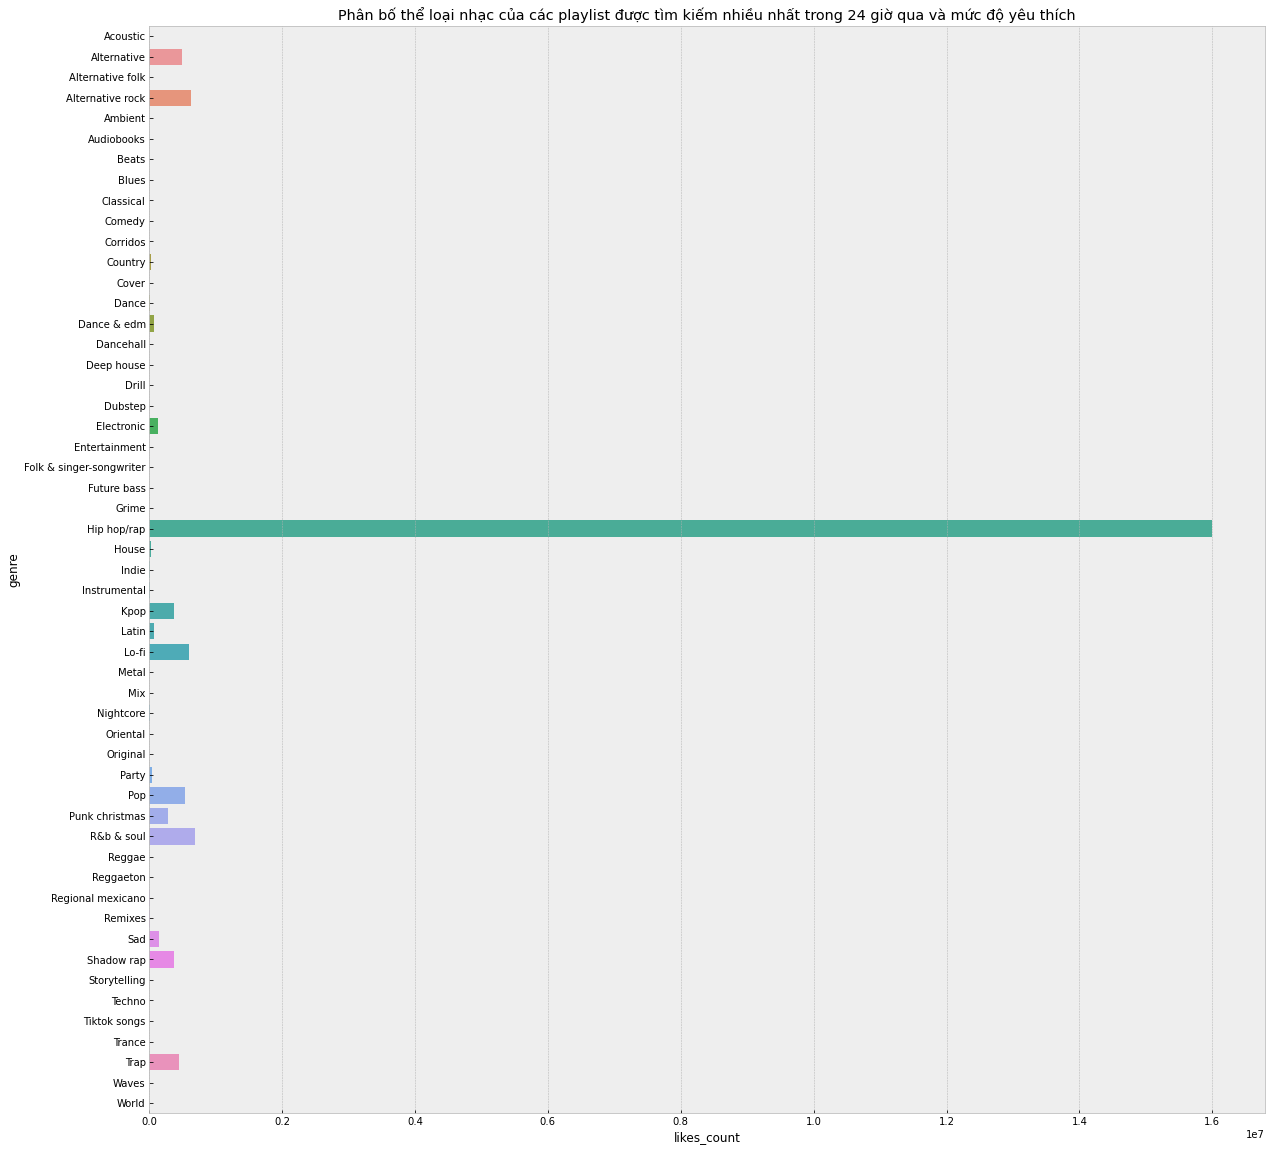

In [133]:
plt.figure(figsize=(20, 20))
sns.barplot(x="likes_count", y="genre", data=total_likes_count_by_genre)
plt.title('Phân bố thể loại nhạc của các playlist được tìm kiếm nhiều nhất trong 24 giờ qua và mức độ yêu thích');

In [145]:
total_likes = total_likes_count_by_genre.sum()[1]
total_likes_count_by_genre['percentage'] = total_likes_count_by_genre['likes_count'] / total_likes * 100

In [147]:
print(f"Tỷ lệ của playlist được yêu thích nhiều nhất thuộc thể loại Hip hop/Rap : {(total_likes_count_by_genre['percentage'].max()):.2f}%")

Tỷ lệ của playlist được yêu thích nhiều nhất thuộc thể loại Hip hop/Rap : 76.06%


**Tìm playlist được yêu thích nhất**

In [153]:
playlist.loc[playlist['likes_count'].idxmax()]

id                                                        250194288
duration                                                    1698265
genre                                                   Hip hop/rap
likes_count                                                  423452
reposts_count                                                 57122
user_id                                                    30994369
set_type                                                      album
track_counts                                                     10
tracks            278175831,278175819,278175802,278175791,278175...
is_purchasable                                                False
display_time                                                50.8387
percentage                                                      NaN
Name: 1538, dtype: object

### 2. Tập user

In [75]:
user = pd.read_csv('Crawl_data/selected_users.csv', sep='\t')
user.head()

,id,comments_count,country_code,followers_count,followings_count,likes_count,playlist_likes_count,playlist_count,track_count,subscription_type,existing_time
0,596252733,0,Unknown,1,3,28,3,3,0,free,20.418975
1,557083830,7,GB,4,21,105,6,15,0,free,22.768458
2,461702466,19,Unknown,3,8,143,1,0,0,free,28.975854
3,99685284,0,Unknown,1687347,15,12,0,8,109,creator-pro-unlimited,76.937871
4,774095092,0,Unknown,2,0,0,0,1,0,free,9.342291


In [76]:
user['id'] = user['id'].astype('object')

**Tóm tắt:**

|Thuộc tính|Kiểu dữ liệu|     Ý nghĩa   |Miền giá trị |
|:--------:|:-------------:|:-----:|:-----:|
|**id**|Chuỗi|Định danh của playlist||
|**comments_count**|Số nguyên|Số lượt bình luận của người dùng|Liên tục (đơn vị: lần)|
|**country_code**|Chuỗi|Mã quốc gia người dùng đăng ký| |
|**followers_count**|Số nguyên|Số người theo dõi user|Liên tục|
|**followings_count**|Số nguyên|Số người user đang theo dõi|Liên tục|
|**likes_count**|Số nguyên|Thể loại nhạc của playlist|Liên tục|
|**playlist_likes_count**|Số nguyên|Số lượng playlist mà user yêu thích|Liên tục|
|**playlist_count**|Số nguyên|Số lượng playlist user đăng tải|Liên tục|
|**track_count**|Số nguyên|Số lượng track của user|Liên tục |
|**subscription_type**|Phân loại|Loại tài khoản mà người dùng đăng ký|free, pro hoặc pro-unlimited|
|**existing_time**|Số thực|Thời gian tài khoản được tạo|Liên tục (đơn vị: tháng)|

#### a.1 Phân tích đơn biến

#### Dữ liệu số

In [77]:
user_num = user.select_dtypes(include = ['float64', 'int64'])

In [78]:
user_num.describe().T

,count,mean,std,min,25%,50%,75%,max
comments_count,1755.0,30.606268,542.967121,0.000000,0.00000,0.000000,3.000000,2.175100e+04
followers_count,1755.0,62201.495726,486485.882840,0.000000,3.00000,7.000000,34.000000,9.870602e+06
followings_count,1755.0,66.272365,207.980990,0.000000,1.00000,9.000000,46.000000,2.010000e+03
likes_count,1755.0,461.472365,1693.093119,0.000000,7.00000,50.000000,332.500000,5.128200e+04
playlist_likes_count,1755.0,37.368091,359.340697,0.000000,0.00000,2.000000,9.000000,1.304700e+04
playlist_count,1755.0,110.324217,526.331409,0.000000,2.00000,5.000000,16.000000,6.151000e+03
track_count,1755.0,11.492877,51.984060,0.000000,0.00000,0.000000,0.000000,8.560000e+02
existing_time,1755.0,46.005682,28.683853,0.238574,21.49051,45.047553,66.741795,1.358236e+02


**Trực quan hóa**

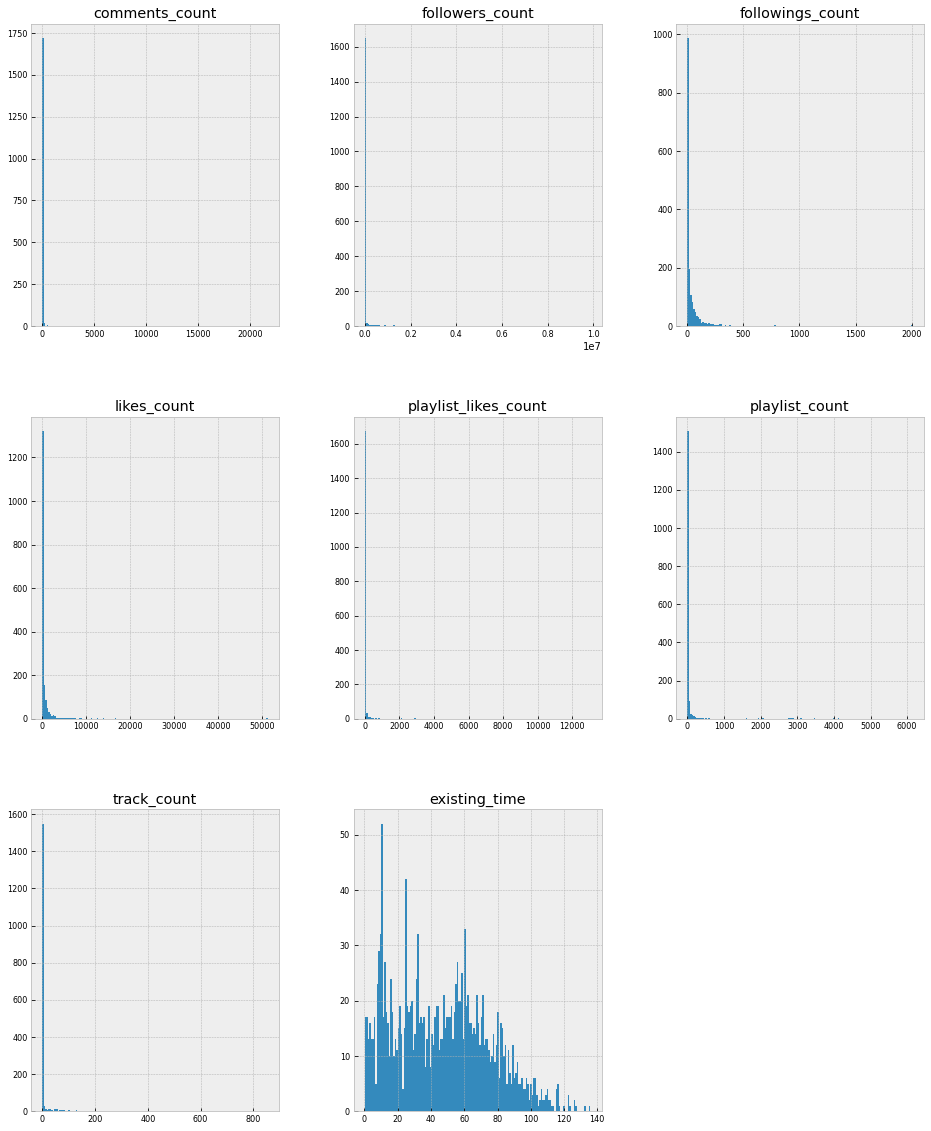

In [79]:
user_num.hist(figsize=(16, 20), bins=150, xlabelsize=8, ylabelsize=8);

**Nhận xét:**
- Người dùng là chủ của các playlist được tìm kiếm nhiều nhất chủ yếu là người dùng mới. 
- Số lượng playlist chủ yếu của các người dùng này nhỏ hơn 1000, tuy nhiên có một vài người dùng sở hữu hơn 3000 - 4000 playlist

##### a.1.1 Thuộc tính `likes_count`
- Hầu hết các người dùng có lượng yêu thích dưới 10000 lượt, có khoảng 4 mẫu có lượng yêu thích từ 10000 - 20000 lượt và có một người dùng nhận được hơn 50000 lượt yêu thích.
- *Có khả năng người nhận được lượng yêu thích cao nhất này là tài khoản của một nghệ sĩ tự đăng tải bài hát của chính họ*.

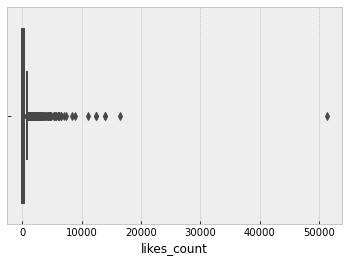

In [25]:
sns.boxplot(data=user_num, x='likes_count');

##### a.1.2 Thuộc tính `comments_count`
- Hầu hết các người dùng có số lần bình luận dưới 2500, tuy nhiên có 1 người dùng bình luận hơn 5000 lần và 1 người dùng bình huận hơn 20000 lần. 

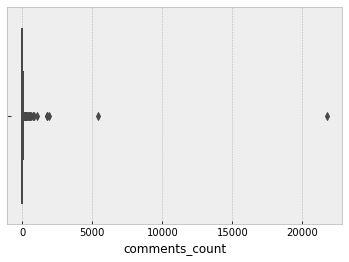

In [24]:
sns.boxplot(data=user_num, x='comments_count');

##### a.1.3 Thuộc tính `followers_count`

##### a.1.4 Thuộc tính `followings_count`

##### a.1.5 Thuộc tính `playlist_likes_count`

##### a.1.6 Thuộc tính `playlist_count`

##### a.1.7 Thuộc tính `track_count`

##### a.1.8 Thuộc tính `existing_time`
- Hầu hết chủ nhân của các playlist được tìm kiếm nhiều cũng là những tài khoản mới lập trong khoảng 5 năm trở lại, tuy vẫn có một tài khoản ngoại lệ đã tồn tại hơn 10 năm. *Có khả năng người dùng này là chủ của playlist có thời gian tồn tại lâu đời nhưng được tìm kiếm nhiều gần đây*.

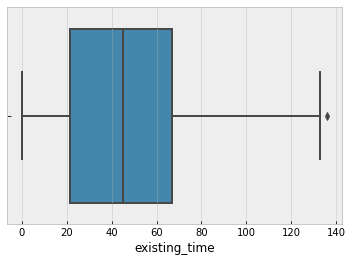

In [32]:
sns.boxplot(data=user_num, x='existing_time');

**Tìm người dùng có lượt yêu thích cao nhất**

**Tìm người dùng có lượt theo dõi nhiều nhất**

**Tìm người dùng có nhiều playlist nhất**

#### Dữ liệu rời rạc

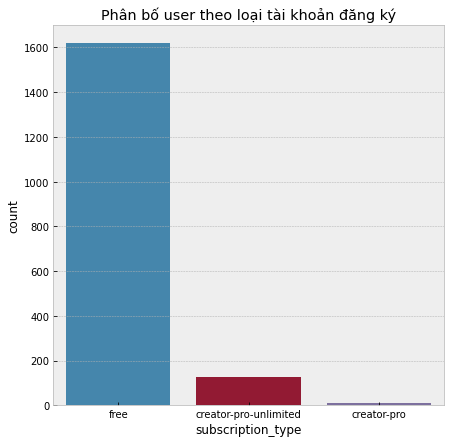

In [45]:
plt.figure(figsize=(7, 7))
sns.countplot(x="subscription_type", data=user)
plt.title('Phân bố user theo loại tài khoản đăng ký');

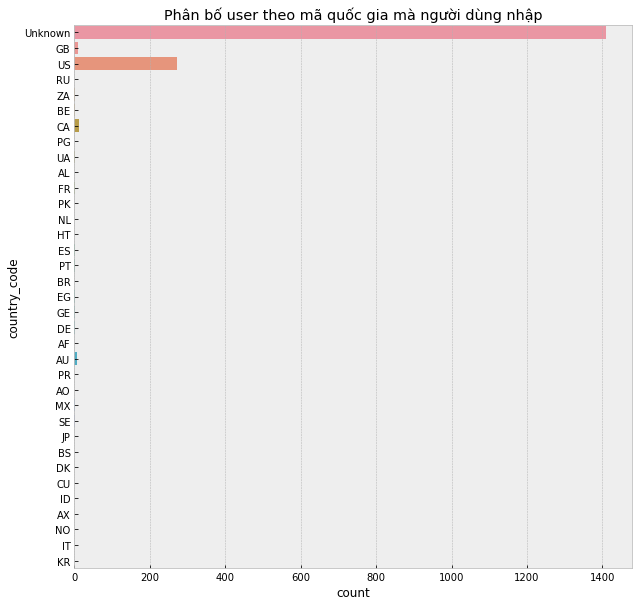

In [44]:
plt.figure(figsize=(10, 10))
sns.countplot(y="country_code", data=user)
plt.title('Phân bố user theo mã quốc gia mà người dùng nhập');

#### a.2 Phân tích đa biến

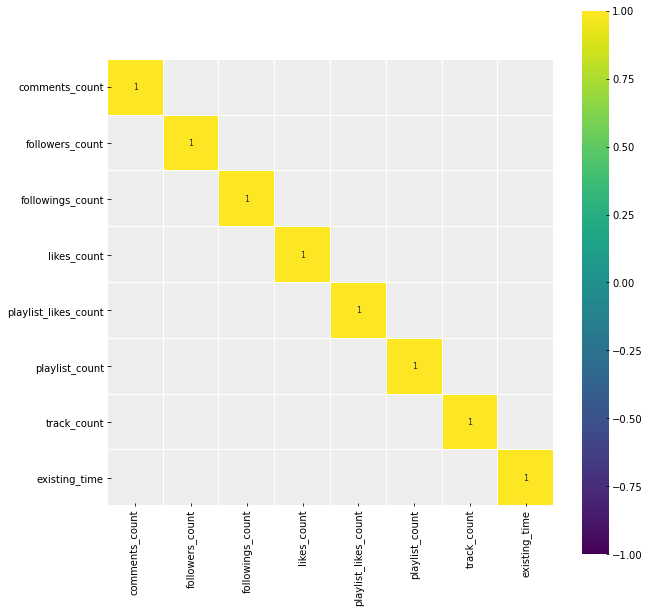

In [8]:
corr = user.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

**Do tập con user_num của tập user có nhiều chiều hơn (có 8 thuộc tính số)) nên lượng tổ hợp phát sinh quá lớn, không thể vẽ bằng sns.pairplot nên đồ án sẽ xét một số cặp và trực quan bằng sns.scatterplot):**
- Thuộc tính `likes_count` và `existing_time` (người dùng lâu năm có tương đương việc nhận được lượt yêu thích cao?)
- Thuộc tính `followers_count` và `playlist_count` (người có nhiều playlist có được theo dõi nhiều hơn không?)
- Thuộc tính `followers_count` và `track_count`
- Thuộc tính `playlist_count` và `track_count`

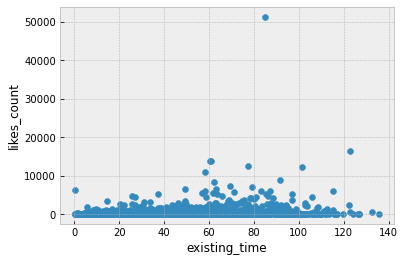

In [14]:
plt.scatter(y=user['likes_count'], x=user['existing_time']);
plt.ylabel('likes_count');
plt.xlabel('existing_time');

**Nhận xét:**
- Hai thuộc tính `likes_count` và `existing_time` nhìn chung không thể hiện quan hệ đáng chú ý. Thông tin rút ra được từ biểu đồ là những người dùng có lượt yêu thích nhiều nhất trong tập dữ liệu là những tài khoản có thời gian tồn tại từ 60 - 120 tháng (5 - 10 năm)

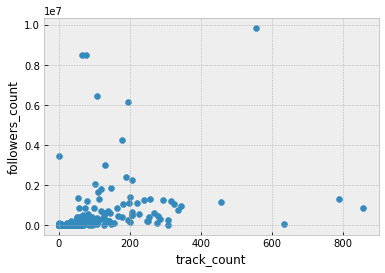

In [13]:
plt.scatter(x=user['track_count'], y=user['followers_count']);
plt.xlabel('track_count');
plt.ylabel('followers_count');

**Nhận xét:**
- Chủ yếu những người có số track ít thì có số lượt theo dõi ít. Đáng chú ý là *có một vài người dùng có lượng track không quá nhiều (<100 track) nhưng lại có lượt theo dõi cao thứ nhì*, có thể các user đó là tài khoản của nghệ sĩ tự quảng bá ca khúc của họ

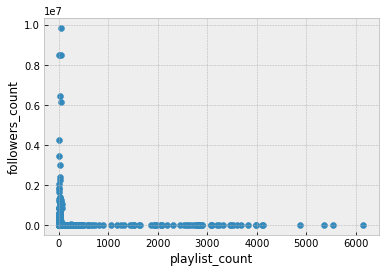

In [15]:
plt.scatter(x=user['playlist_count'], y=user['followers_count']);
plt.xlabel('playlist_count');
plt.ylabel('followers_count');

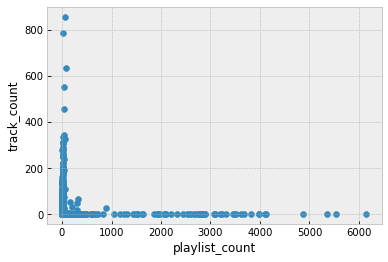

In [16]:
plt.scatter(x=user['playlist_count'], y=user['track_count']);
plt.xlabel('playlist_count');
plt.ylabel('track_count');

**Nhận xét:**
- Có vẻ không có mối quan hệ đặc biệt nào giữa số lượng playlist của tài khoản và lượt theo dõi của tài khoản ấy.
- Tương tự, giữa số lượng playlist và số lượng track cũng không cung cấp thông tin đặc biệt.

**Tìm user được yêu thích nhất**

In [156]:
user.loc[user['likes_count'].idxmax()]

id                         61852411
comments_count                 5408
country_code                     US
followers_count               23460
followings_count                394
likes_count                   51282
playlist_likes_count           3367
playlist_count                   59
track_count                       4
subscription_type       creator-pro
existing_time               84.9327
Name: 414, dtype: object

### 3. Tập track

In [47]:
track = pd.read_csv('Crawl_data/selected_tracks.csv', sep='\t')
track.head()

,id,full_duration,genre,comment_count,likes_count,playback_count,reposts_count,download_count,display_time
0,187460600,202362,Unknown,470,48016,2497040,9761,0,69.571361
1,247883444,231700,Unknown,56,35182,2584991,1764,0,56.682940
2,151431689,231361,Hip hop/rap,291,20036,1831890,1491,0,77.503395
3,508699284,174749,Unknown,613,103765,7880344,2128,0,25.199696
4,759765964,133773,Unknown,1207,61040,5024515,2400,0,8.861780


In [48]:
track['id'] = track['id'].astype('object')

**Tóm tắt:**

|Thuộc tính|Kiểu dữ liệu|     Ý nghĩa   |Miền giá trị |
|:--------:|:-------------:|:-----:|:-----:|
|**id**|Chuỗi|Định danh của playlist||
|**full_duration**|Số nguyên|Độ dài của track nhạc|Liên tục (đơn vị: mili giây)|
|**genre**|Chuỗi|Thể loại nhạc của track| 60 thể loại nhạc |
|**comments_count**|Số nguyên|Số lượt bình luận track nhận được|Liên tục (đơn vị: lần)|
|**likes_count**|Số nguyên|Số lượt yêu thích của track|Liên tục|
|**playback_count**|Số nguyên|Số lượt nghe của track|Liên tục|
|**reposts_count**|Số nguyên|Số lượt đăng lại track| Liên tục  |
|**download_count**|Số nguyên|Số lượt tải của track|Liên tục|
|**display_time**|Số thực|Thời gian playlist đã được đăng|Liên tục (đơn vị: tháng)|

#### a.1 Phân tích đơn biến

In [49]:
track_num = track.select_dtypes(include = ['float64', 'int64'])

In [50]:
track_num.describe().T

,count,mean,std,min,25%,50%,75%,max
full_duration,6434.0,2.915342e+05,6.422301e+05,131.000000,159060.000000,1.947040e+05,2.332635e+05,1.047266e+07
comment_count,6434.0,1.950513e+03,6.592559e+03,0.000000,44.000000,2.345000e+02,1.221000e+03,2.378030e+05
likes_count,6434.0,1.156466e+05,2.390388e+05,0.000000,4607.500000,2.645700e+04,1.104548e+05,2.979722e+06
playback_count,6434.0,8.786000e+06,1.943012e+07,0.000000,315743.250000,1.782517e+06,7.897245e+06,2.627160e+08
reposts_count,6434.0,6.524561e+03,1.725483e+04,0.000000,176.000000,1.025000e+03,4.960750e+03,3.274450e+05
download_count,6434.0,3.706036e+03,4.369518e+04,0.000000,0.000000,0.000000e+00,0.000000e+00,1.642094e+06
display_time,6434.0,4.324809e+01,3.212376e+01,0.157382,17.262806,3.883238e+01,6.355003e+01,3.583154e+02


**Trực quan hóa**

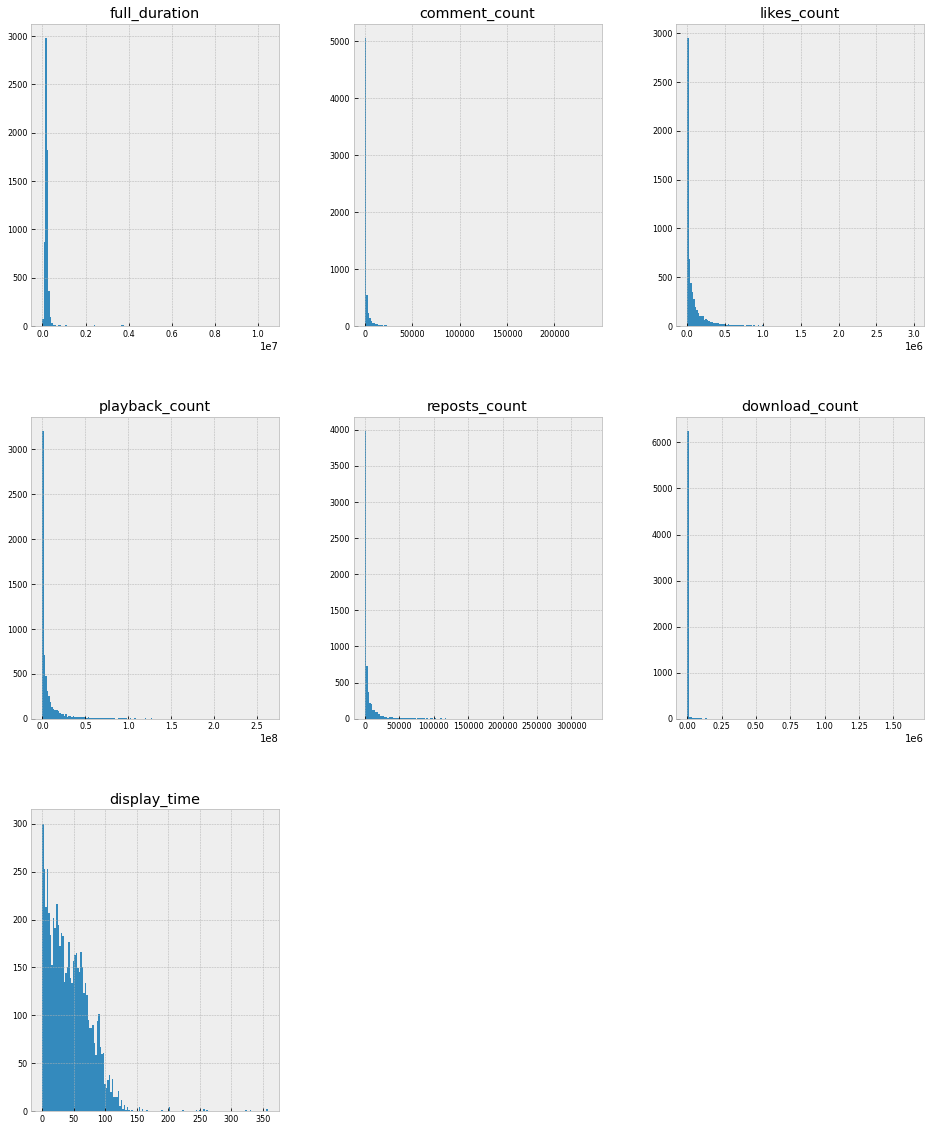

In [51]:
track_num.hist(figsize=(16, 20), bins=150, xlabelsize=8, ylabelsize=8);

#### a.2 Phân tích đa biến

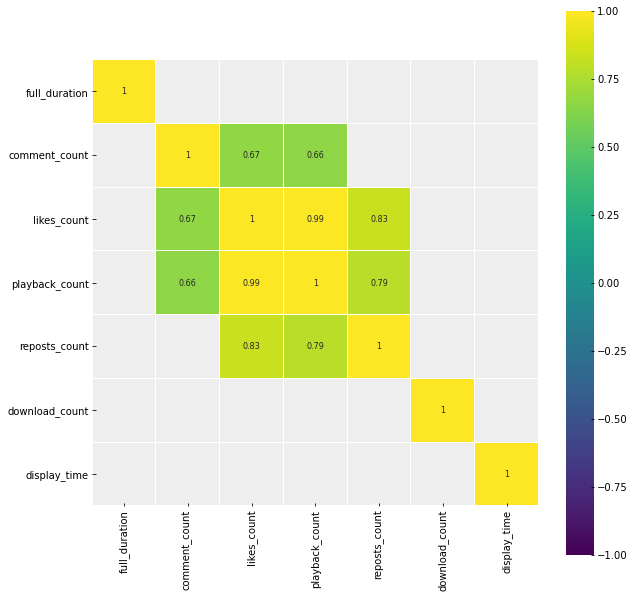

In [52]:
corr = track.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

**Nhận xét:**
- Dựa vào heatmap trên, ta thấy được các mối quan hệ tương quan thuận sau:
    - `reposts_count` và `likes_count`: track được yêu thích càng nhiều thì càng được tài khoản khác chia sẻ nhiều hơn và ngược lại.
    - `reposts_count` và `playback_count`: track được nghe càng nhiều thì càng đuợc tài khoản khác chia sẻ nhiều hơn và ngược lại.
    - `likes_count` và `comments_count`: track càng được yêu thích thì càng nhiều người bình luận và ngược lại.
    - `playback_count` và `comments_count`: track được nghe càng nhiều thì càng nhiều người bình luận và ngược lại.

#### Dữ liệu rời rạc

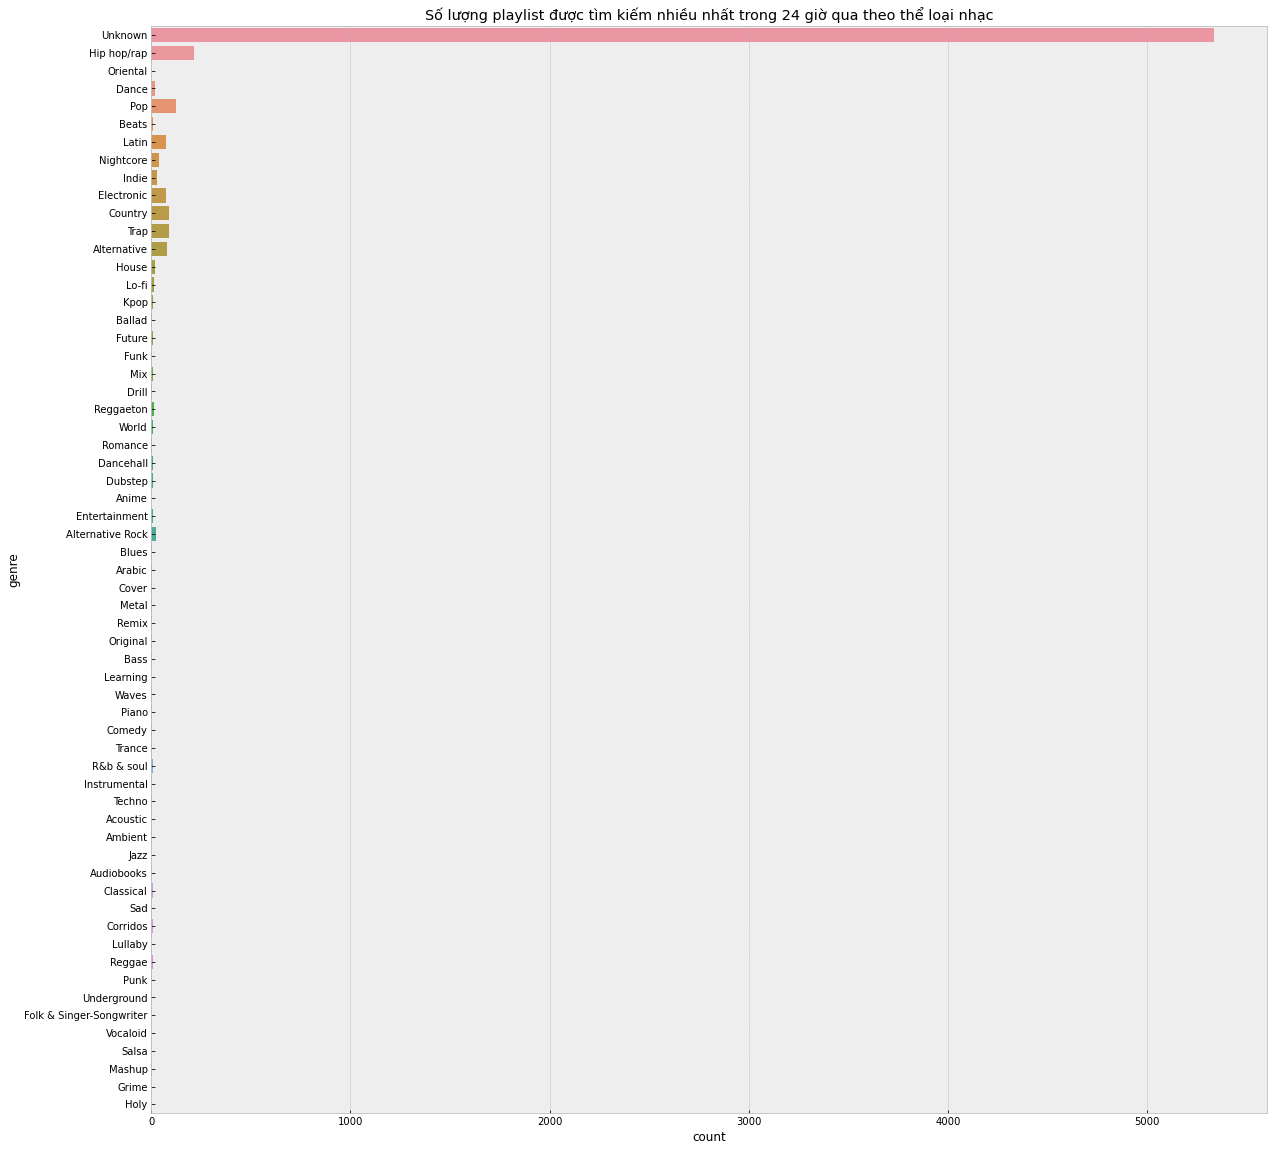

In [53]:
plt.figure(figsize=(20, 20))
sns.countplot(y="genre", data=track)
plt.title('Số lượng playlist được tìm kiếm nhiều nhất trong 24 giờ qua theo thể loại nhạc');

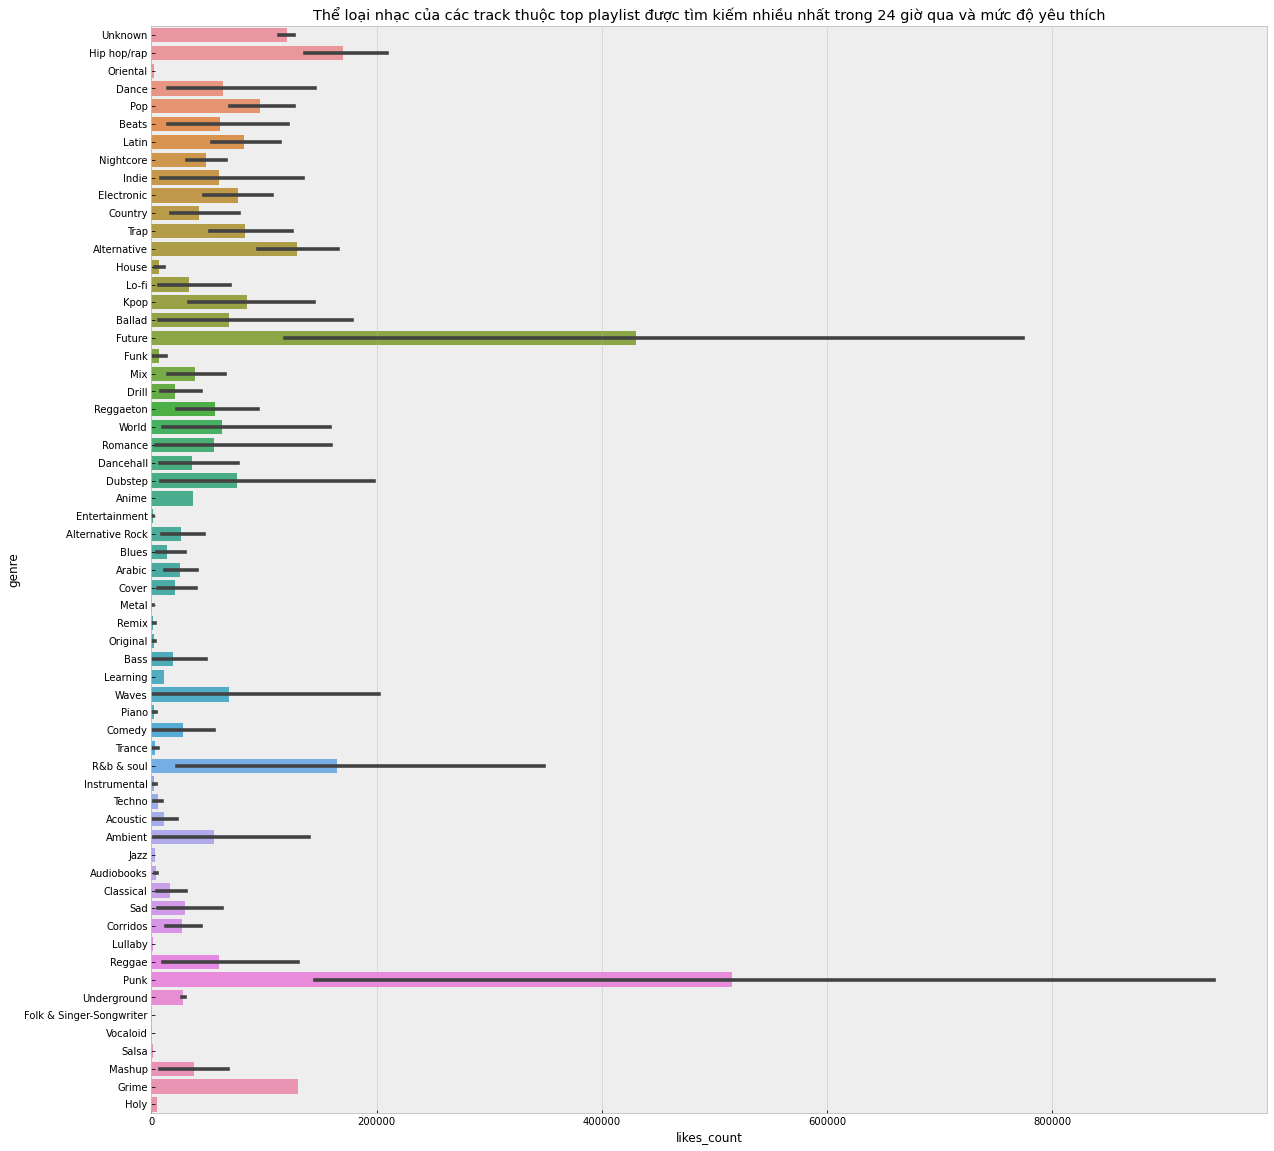

In [55]:
plt.figure(figsize=(20, 20))
sns.barplot(x="likes_count", y="genre", data=track)
plt.title('Thể loại nhạc của các track thuộc top playlist được tìm kiếm nhiều nhất trong 24 giờ qua và mức độ yêu thích');

**Tìm track được yêu thích nhất**

In [154]:
track.loc[track['likes_count'].idxmax()]

id                193781466
full_duration        176656
genre               Unknown
comment_count         24859
likes_count         2979722
playback_count    214738876
reposts_count        295767
download_count            0
display_time         68.332
Name: 2961, dtype: object

**Tìm track được chia sẻ nhiều nhất**

In [155]:
track.loc[track['reposts_count'].idxmax()]

id                113662676
full_duration        269687
genre               Unknown
comment_count         49603
likes_count         1980541
playback_count    147748935
reposts_count        327445
download_count            0
display_time        85.2369
Name: 5637, dtype: object

## IV - Trả lời câu hỏi

-  Các playlist thuộc thể loại nhạc nào được tìm kiếm nhiều nhất trong 24 giờ qua (tính tới thời điểm 05/11/2020)?
    - Trả lời: **Các playlist nhạc Hip hop/rap được tìm kiếm nhiều nhất trong 24 giờ qua với tỷ lệ 73.48% so với tổng số playlist**
    - Minh chứng: Dựa trên biểu đồ  `Phân bố playlist được tìm kiếm nhiều nhất trong 24 giờ qua theo thể loại nhạc` 
    
    
- Các playlist thuộc thể loại nhạc nào được yêu thích nhiều nhất?
     - Trả lời: **Các playlist nhạc Hip hop/rap cũng được yêu thích nhiều nhất 24 giờ qua với tỷ lệ 76.06% so với tổng số playlist**
      - Minh chứng: Dựa trên biểu đồ  `Phân bố thể loại nhạc của các playlist được tìm kiếm nhiều nhất trong 24 giờ qua và mức độ yêu thích` 
      

- Playlist nào được yêu thích nhiều nhất?
    - Trả lời: **Playlist được yêu thích nhiều nhất thuộc nhạc Hip hop/rap, có playlist_id = 250194288**
    
    
- Track nhạc nào được yêu thích nhiều nhất? Nhiều lượt chia sẻ nhất?
    - Trả lời: **Track được yêu thích nhất là bài Major Lazer & DJ Snake - Lean On của nghệ sĩ Major Lazer, track được chia sẻ nhiều nhất là bài All of me của John Legend**
    
 
- Có thể loại nhạc mới nào xuất hiện trong top các playlist hoặc track được tìm kiếm? *Thể loại nhạc được xem là mới nếu nó không nằm trong danh sách thể loại mặc định của Soundcloud*
    - Trả lời: **Có khá nhiều loại nhạc mới như Lo-fi, House, Holy xuất hiện trong top các playlist được tìm kiếm. Điều này cho thấy bên cạnh các loại nhạc quen thuộc, người nghe nhạc đang có xu hướng quan tâm đến các thể loại mới mẻ hơn**
    - Minh chứng: Dựa trên biểu đồ `Thể loại nhạc của các track thuộc top playlist được tìm kiếm nhiều nhất trong 24 giờ qua và mức độ yêu thích`
    
   
- User nào đang được yêu thích nhất?
    - Trả lời: **User đang được yêu thích nhất là Hip hop Repost - [link profile](https://soundcloud.com/hip_hop_repost)**

## V - Tham khảo
- [Soundcloud API](https://developers.soundcloud.com/docs/api/reference#tracks)
- [Ý nghĩa các trường API](https://pysoundcloud.readthedocs.io/en/latest/api.html)
- [EDA Spotify](https://astimegoesby111.github.io/Spotify-Music-Data-Analysis/)
- [EDA Spotify Kaggle](https://www.kaggle.com/saiyan6174/eda-on-top-spotify-songs#Exploratory-Data-Analysis)
- [EDA CMU](https://www.stat.cmu.edu/~hseltman/309/Book/chapter4.pdf)